In [1]:
import matplotlib
matplotlib.use('pdf')

%pylab inline
import seaborn; seaborn.set_style('whitegrid')

from avocado import *
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [11]:
metrics = numpy.zeros((12, 3, 1014))

with open('../../scripts/ExistingRoadmapTracks.txt', 'r') as infile:
    for k, line in tqdm(enumerate(infile)):
        celltype, assay = line.split()

        for i in range(22):
            with open('results/{}.{}.chr{}.txt'.format(celltype, assay, i+1), 'r') as results:
                for j, line in enumerate(results):
                    line = numpy.array(map(float, line.split()))
                    metrics[j, :, k] += line * chromosome_lengths[i] / sum(chromosome_lengths)

1014it [00:47, 21.56it/s]


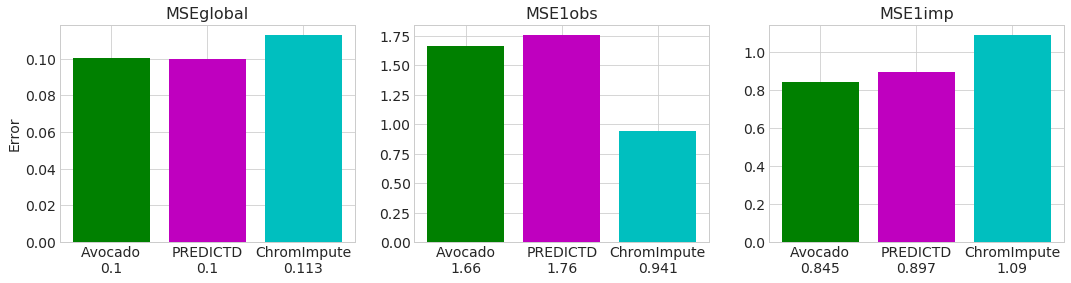

In [13]:
mses =  metrics[0].mean(axis=1) 
mses1obs = metrics[1].mean(axis=1) 
mses1imp = metrics[2].mean(axis=1) 

plt.figure(figsize=(18, 4), facecolor='w')
plt.subplot(131)
plt.title("MSEglobal", fontsize=16)
plt.bar([0], [mses[2]], color='g')
plt.bar([1], [mses[1]], color='m')
plt.bar([2], [mses[0]], color='c')
plt.xticks(range(3), ["Avocado\n{:3.3}".format(mses[2]), 
                      "PREDICTD\n{:2.2}".format(mses[1]),
                      "ChromImpute\n{:3.3}".format(mses[0])], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Error", fontsize=14)


plt.subplot(132)
plt.title("MSE1obs", fontsize=16)
plt.bar([0], [mses1obs[2]], color='g')
plt.bar([1], [mses1obs[1]], color='m')
plt.bar([2], [mses1obs[0]], color='c')
plt.xticks(range(3), ["Avocado\n{:3.3}".format(mses1obs[2]), 
                      "PREDICTD\n{:3.3}".format(mses1obs[1]), 
                      "ChromImpute\n{:3.3}".format(mses1obs[0]),], fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(133)
plt.title("MSE1imp", fontsize=16)
plt.bar([0], [mses1imp[2]], color='g')
plt.bar([1], [mses1imp[1]], color='m')
plt.bar([2], [mses1imp[0]], color='c')
plt.xticks(range(3), ["Avocado\n{:3.3}".format(mses1imp[2]),
                      "PREDICTD\n{:3.3}".format(mses1imp[1]),
                      "ChromImpute\n{:3.3}".format(mses1imp[0])
                      ], fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [8]:
print mses[2] / mses[0], mses[2] / mses[1]
print mses1obs[2] / mses1obs[0], mses1obs[2] / mses1obs[1]
print mses1imp[2] / mses1imp[0], mses1imp[2] / mses1imp[1]

0.8873210493736936 1.0026023597392024
1.7632339750150396 0.9445456947963111
0.7744675408604572 0.9422463217279587


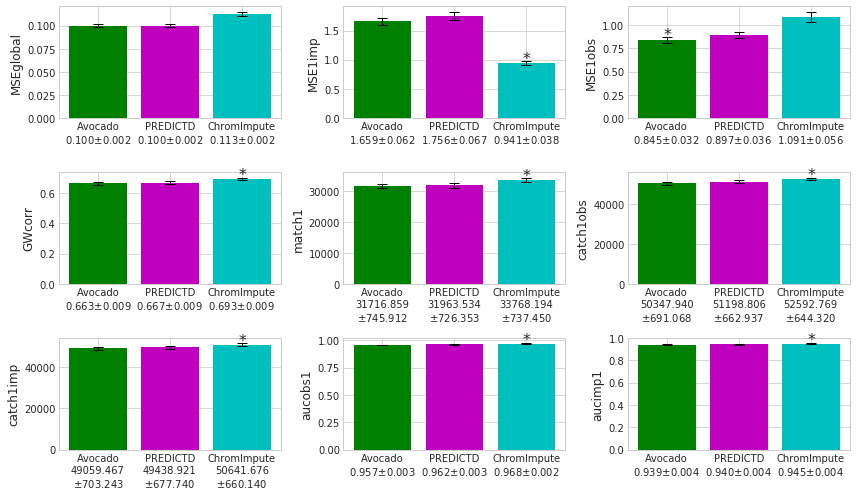

In [84]:
plt.figure(figsize=(12, 7), facecolor='w')

titles = ['MSEglobal', 'MSE1imp', 'MSE1obs', 'GWcorr', 'match1', 'catch1obs', 'catch1imp', 'aucobs1', 'aucimp1']
for i, (metric, title) in enumerate(zip(metrics[:9], titles)):
    mean = numpy.around(metric.mean(axis=1), 3)
    std = numpy.around(metric.std(axis=1), 3)
    
    a2 = mean[2] - norm.interval(0.95, loc=mean[2], scale=std[2] / numpy.sqrt(1014.))[0]
    a1 = mean[1] - norm.interval(0.95, loc=mean[1], scale=std[1] / numpy.sqrt(1014.))[0]
    a0 = mean[0] - norm.interval(0.95, loc=mean[0], scale=std[0] / numpy.sqrt(1014.))[0]
    
    plt.subplot(3, 3, i+1)
    plt.ylabel(title, fontsize=12)
    plt.yticks(fontsize=10)
    plt.bar([0], [mean[2]], color='g')
    plt.errorbar([0], [mean[2]], [a2], color='k', capsize=5, elinewidth=1)
    
    plt.bar([1], [mean[1]], color='m')
    plt.errorbar([1], [mean[1]], [a1], color='k', capsize=5, elinewidth=1)
    
    plt.bar([2], [mean[0]], color='c')
    plt.errorbar([2], [mean[0]], [a0], color='k', capsize=5, elinewidth=1)
    
    mean = numpy.around(mean, 3)
    std = numpy.around(std, 3)
    a0, a1, a2 = numpy.around([a0, a1, a2], 3)
    
    if 4 <= i <= 6:
        plt.xticks(range(3), ["Avocado\n{:3.3f}\n$\pm${:3.3f}".format(mean[2], a2), 
                              "PREDICTD\n{:3.3f}\n$\pm${:3.3f}".format(mean[1], a1),
                              "ChromImpute\n{:3.3f}\n$\pm${:3.3f}".format(mean[0], a0)], fontsize=10)
    else:
        plt.xticks(range(3), ["Avocado\n{:3.3f}$\pm${:3.3f}".format(mean[2], a2), 
                              "PREDICTD\n{:3.3f}$\pm${:3.3f}".format(mean[1], a1),
                              "ChromImpute\n{:3.3f}$\pm${:3.3f}".format(mean[0], a0)], fontsize=10)
        
    idx1, idx2, idx3 = numpy.argsort(mean)
    if i > 2:
        idx3, idx2, idx1 = idx1, idx2, idx3
    
    p = ttest_rel(metric[idx1], metric[idx2])[1]
    if p * 3 < 0.01:
        plt.text(1.95-idx1, mean[idx1], "*", fontsize=16)
    
plt.tight_layout()
plt.savefig('Avocado-supplement-error-metrics.pdf')
plt.show()

In [38]:
from scipy.stats import ttest_rel

ttest_rel(metrics[1][1], metrics[0][2])

Ttest_relResult(statistic=48.95576520688496, pvalue=3.1475756173007676e-269)

In [49]:
from scipy.stats import norm

a, b = norm.interval(0.95, loc=metrics[0][0].mean(), scale=metrics[0][0].std()/numpy.sqrt(1014.))
a - metrics[0][0].mean(), metrics[0][0].mean() - b

(-0.002093116220952068, -0.002093116220952068)

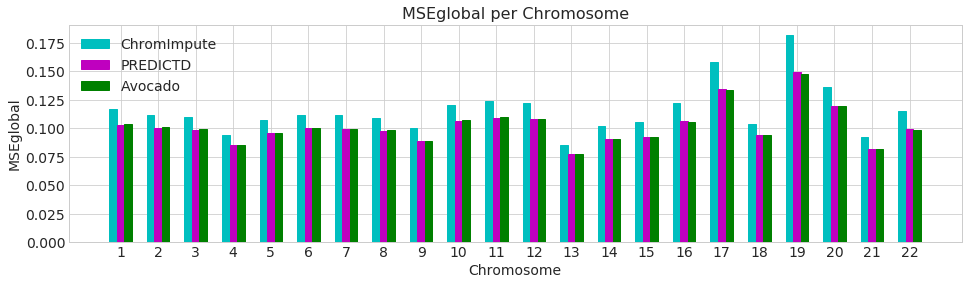

In [9]:
plt.figure(figsize=(16, 4), facecolor='w')
plt.title("MSEglobal per Chromosome", fontsize=16)
plt.bar(numpy.arange(22)-0.2, mse[0] / n, width=0.2, facecolor='c', edgecolor='c', label="ChromImpute")
plt.bar(numpy.arange(22), mse[1] / n, width=0.2, facecolor='m', edgecolor='m', label="PREDICTD")
plt.bar(numpy.arange(22)+0.2, mse[2] / n, width=0.2, facecolor='g', edgecolor='g', label="Avocado")
plt.xticks(range(22), range(1, 23), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MSEglobal", fontsize=14)
plt.xlabel("Chromosome", fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.show()

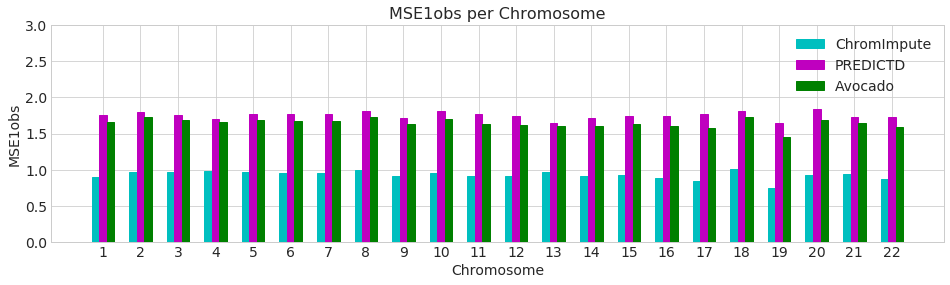

In [10]:
plt.figure(figsize=(16, 4), facecolor='w')
plt.title("MSE1obs per Chromosome", fontsize=16)
plt.bar(numpy.arange(22)-0.2, mse1obs[0] / n, width=0.2, facecolor='c', edgecolor='c', label="ChromImpute")
plt.bar(numpy.arange(22), mse1obs[1] / n, width=0.2, facecolor='m', edgecolor='m', label="PREDICTD")
plt.bar(numpy.arange(22)+0.2, mse1obs[2] / n, width=0.2, facecolor='g', edgecolor='g', label="Avocado")
plt.xticks(range(22), range(1, 23), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MSE1obs", fontsize=14)
plt.xlabel("Chromosome", fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.ylim(0, 3)
plt.show()

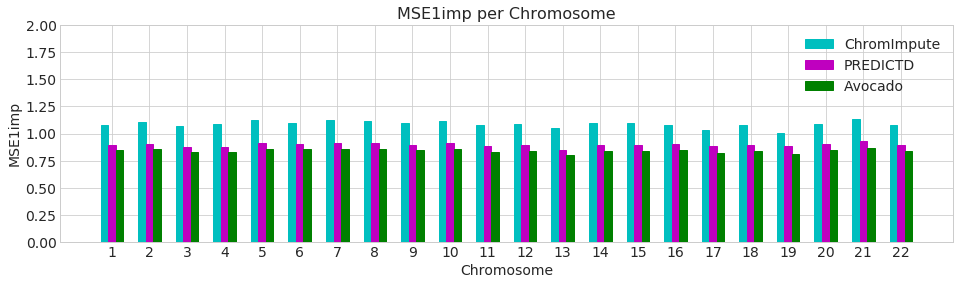

In [11]:
plt.figure(figsize=(16, 4), facecolor='w')
plt.title("MSE1imp per Chromosome", fontsize=16)
plt.bar(numpy.arange(22)-0.2, mse1imp[0] / n, width=0.2, facecolor='c', edgecolor='c', label="ChromImpute")
plt.bar(numpy.arange(22), mse1imp[1] / n, width=0.2, facecolor='m', edgecolor='m', label="PREDICTD")
plt.bar(numpy.arange(22)+0.2, mse1imp[2] / n, width=0.2, facecolor='g', edgecolor='g', label="Avocado")
plt.xticks(range(22), range(1, 23), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MSE1imp", fontsize=14)
plt.xlabel("Chromosome", fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.ylim(0, 2)
plt.show()

In [ ]:
plt.figure(figsize=(14, 4), facecolor='w')

plt.title("Percentage Improvement per Chromosome", fontsize=16)
plt.bar(range(22), (1. - avo_sse / chrom_sse) * 100, facecolor='c', edgecolor='c')
plt.xticks(range(22), range(1, 23), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Percent MSE Reduction", fontsize=14)
plt.xlabel("Chromosome", fontsize=14)
plt.show()

In [78]:
data = numpy.zeros((3, 3))

k = 1. * numpy.array(chromosome_lengths) / sum(chromosome_lengths) / 1014.

with open('../../scripts/ExistingRoadmapTracks.txt', 'r') as infile:
    for line in tqdm(infile):
        celltype, assay = line.split()

        for i in range(22):
            data += numpy.loadtxt("results/{}.{}.chr{}.txt".format(celltype, assay, i+1))[-3:] * k[i]

1014it [00:40, 24.92it/s]


In [79]:
numpy.around(data, 3)

array([[0.325, 0.258, 0.249],
       [0.149, 0.129, 0.13 ],
       [0.316, 0.267, 0.26 ]])

In [86]:
print numpy.around(data[1, 1] - data[1, 2], 8)

-7.889e-05


In [87]:
0.00007889

7.889e-05

In [85]:
prs, rocs, mses, recalls, precisions = [], [], [], [], []
n = 127

for assay in assays:
    pr, roc, mse, recall, precision = [], [], [], [], []
    
    for i in tqdm(range(1, n)):
        try:
            data = numpy.load('peaks/{}.chr20.idx{}.npy'.format(assay, i))
        except:
            data = numpy.zeros_like(data)
        
        roc.append(data[:,0])
        pr.append(data[:,1])
        mse.append(data[:,2])
        recall.append(data[:,3])
        precision.append(data[:,4])
    
    rocs.append(roc)
    prs.append(pr)
    mses.append(mse)
    recalls.append(recall)
    precisions.append(precision)
    
prs = numpy.array(prs)
rocs = numpy.array(rocs)
mses = numpy.array(mses)
recalls = numpy.array(recalls)
precisions = numpy.array(precisions)

100%|██████████| 126/126 [00:00<00:00, 10438.13it/s]


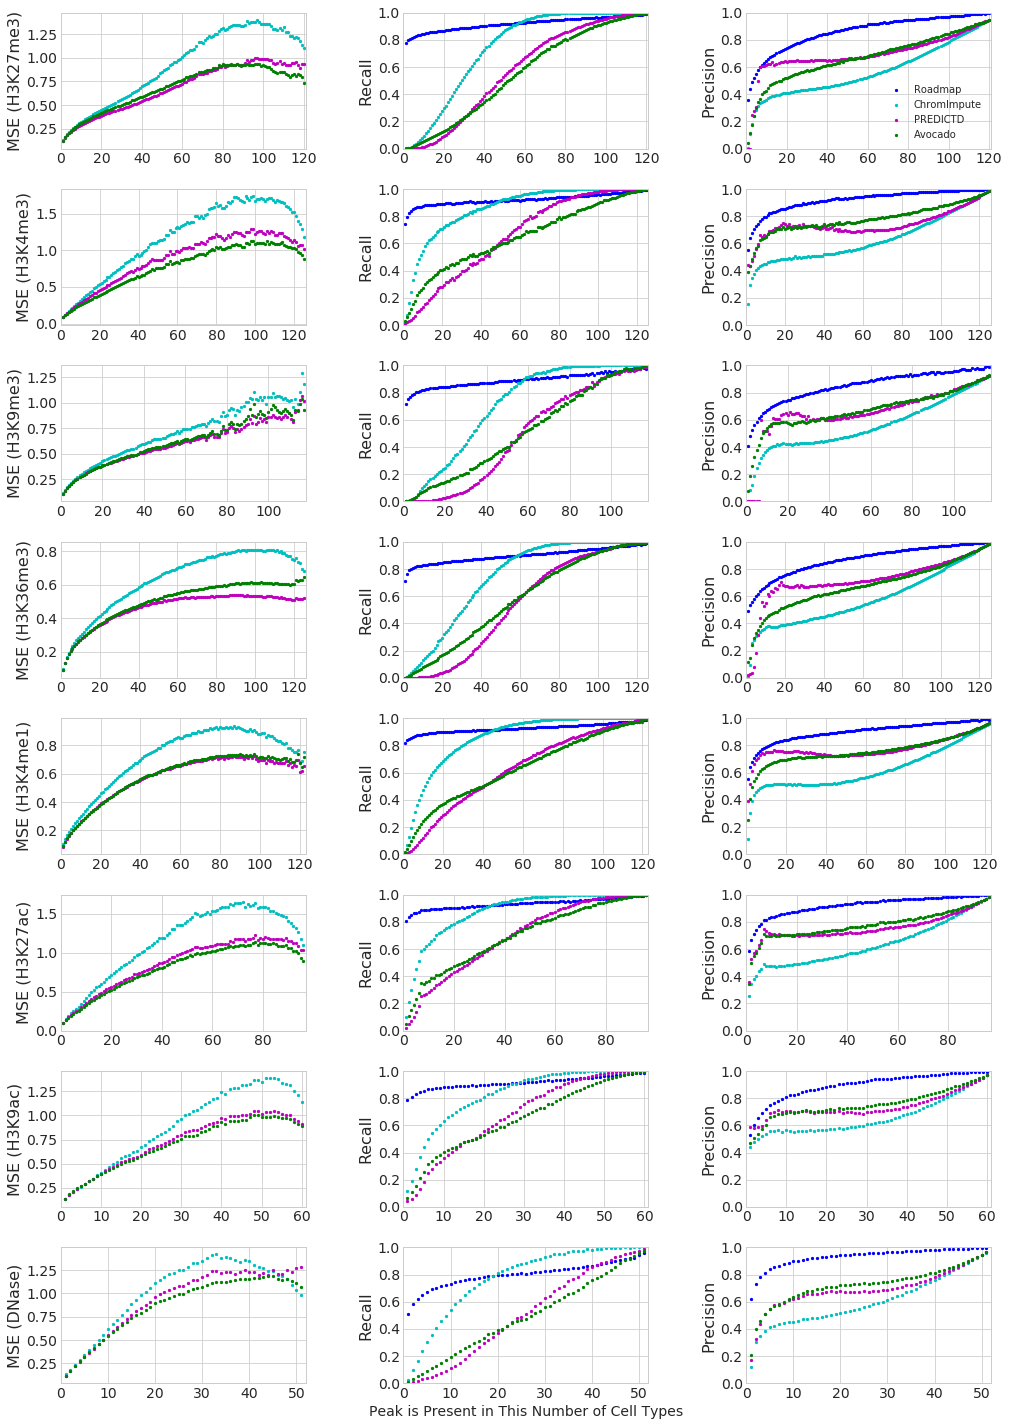

In [92]:
plt.figure(figsize=(14, 20), facecolor='w')

for i in range(8):
    n = (mses[i,:,1] != 0).sum()
    if n < 50:
        continue

    #plt.figure(figsize=(16, 4), facecolor='w')
    #plt.subplot(131)
    plt.subplot(8, 3, (i*3)+1)
    plt.scatter(range(1, n), mses[i,:,1][:n-1], color='c', s=5, label="ChromImpute")
    plt.scatter(range(1, n), mses[i,:,2][:n-1], color='m', s=5, label="PREDICTD")
    plt.scatter(range(1, n), mses[i,:,3][:n-1], color='g', s=5, label="Avocado")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("MSE ({})".format(assays[i]), fontsize=16)
    plt.xlim(0, n)

    #plt.subplot(132)
    plt.subplot(8, 3, (i*3)+2)
    plt.scatter(range(1, n), recalls[i,:,0][:n-1], color='b', s=5, label="Roadmap")
    plt.scatter(range(1, n), recalls[i,:,1][:n-1], color='c', s=5, label="ChromImpute")
    plt.scatter(range(1, n), recalls[i,:,2][:n-1], color='m', s=5, label="PREDICTD")
    plt.scatter(range(1, n), recalls[i,:,3][:n-1], color='g', s=5, label="Avocado")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Recall", fontsize=16)
    plt.xlim(0, n)
    plt.ylim(0, 1)
    
    if i == 7:
        plt.xlabel("Peak is Present in This Number of Cell Types", fontsize=14)

    #plt.subplot(133)
    plt.subplot(8, 3, (i*3)+3)
    plt.scatter(range(1, n), precisions[i,:,0][:n-1], color='b', s=5, label="Roadmap")
    plt.scatter(range(1, n), precisions[i,:,1][:n-1], color='c', s=5, label="ChromImpute")
    plt.scatter(range(1, n), precisions[i,:,2][:n-1], color='m', s=5, label="PREDICTD")
    plt.scatter(range(1, n), precisions[i,:,3][:n-1], color='g', s=5, label="Avocado")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, n)
    plt.ylim(0, 1)
    plt.ylabel("Precision", fontsize=16)
    if i == 0:
        plt.legend(fontsize=10, loc=4)
        
    #plt.show()

plt.tight_layout()
plt.savefig("Avocado-Supplement_peaks.pdf")
plt.show()